In [1]:
import numpy as np
import pandas as pd
import gc
#import lightgbm as lgb
import warnings
import gc
from sklearn.preprocessing import StandardScaler
import matplotlib as  mpl
from matplotlib  import pyplot as plt
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False
from datetime import timedelta
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
import os
os.chdir("C:\\Users\\linxiong.ruan\\Desktop")

In [3]:
%%time
dataset = pd.read_csv('dataset.csv', index_col=0)
dbd_faultcode = pd.read_csv('dbd_faultcode.csv', encoding='GBK' )
train_data = dataset.merge(dbd_faultcode,how = 'left',on = ["SPN","FMI"])
up_data = train_data
up_data.COLLECTTIME = pd.to_datetime(up_data.COLLECTTIME)
up_data.sort_values(by='COLLECTTIME', inplace=True)
# 删除明显异常的行
drop_rows = [0, 1, 2, 3]
drop_rows.extend([x for x in range(1875076, 1875088)])
up_data.drop(drop_rows, axis=0, inplace=True)
# 默认填充为0
up_data["FLAG"] = 0
# 筛选出故障编码不为空的UNIQUENO(一个UNIQUENO可假设为一台机器)
prob_uniqs = up_data[up_data.CODE.notnull()].UNIQUENO.unique()

Wall time: 32.2 s


In [4]:
%%time
# 出现故障的时间段进行标记
'''
minutes = 300
'''
# 设定优先级，对于少数种类的故障，优先标记
code_prev = {
    1206: 0,
    1141: 1,
    1182: 2,
    1168: -1,
    1239: -1,
    1168: -1,
    1211: -1,
    1216: -1,
    1209: -1,
    1145: -1,
    1341: -1,
    1246: -1,
    1215: -1,
    1122: -1
}

delta = timedelta(minutes = 300)
left_delta = delta
right_delta = delta
# 从有故障的设备列表中取出一台设备
for dev_id in prob_uniqs:
    # 取出这台设备的全部数据
    cdf = up_data[up_data.UNIQUENO == dev_id].copy()
    cdf['index'] = cdf.index
    cdf.reset_index(inplace=True)
    # 取出这台设备故障码不为空的数据
    notna_cdf = cdf[cdf.CODE.notna()]
#     print(datetime.now(), dev_id, cdf.shape[0], notna_cdf.shape[0])
    cdf_len = cdf.shape[0]
    # 在这台设备数据中遍历不为空的位置
    for i in notna_cdf.index:
        dt = cdf.at[i, 'COLLECTTIME']
        code = cdf.at[i, 'CODE']
        # 在前后时间间隔内打标签
        for y in range(i, -1, -1):
            y_code = up_data.at[cdf.at[y, 'index'], 'FLAG']
            if y_code > 0 and code_prev[y_code] >= code_prev[code]:
                break
            elif cdf.at[y, 'COLLECTTIME'] >= dt - left_delta:
                up_data.at[cdf.at[y, 'index'], 'FLAG'] = code
            else:
                break
        
        for y in range(i + 1, cdf_len, 1):
            y_code = up_data.at[cdf.at[y, 'index'], 'FLAG']
            if y_code > 0 and code_prev[y_code] >= code_prev[code]:
                break
            elif cdf.at[y, 'COLLECTTIME'] <= dt + right_delta:
                up_data.at[cdf.at[y, 'index'], 'FLAG'] = code
            else:
                break
print('done')

done
Wall time: 33.5 s


In [5]:
%%time
#columns_filter,util_cols由人工提供
columns_filter = ['CD_VP_UNIQUENO', 'AREA', 'ROAD', 'LONGITUDE', 'LATITUDE', 'SPEED',
       'DIRECTION', 'ALTITUDE', 'ACCSTATE', 'POWERDOWNSTATE', 'LOCATIONSTATE',
       'WORKHOURS', 'ACCRUNTIMES', 'ACCWORKTIMES', 'PRESSURE',
       'WATERTEMPERATURE', 'OILLOCATION', 'OILTEMPERATURE', 'OILPRESSURE',
       'ROUNDSPEED', 'ACCEXCCOUNT', 'GSMSIGNAL', 'WORKDETAILID',
       'VEHICLESTATUS', 'TERMINALSTATUS', 'SATELLITE', 'TERMINALEL_OUTSIDE',
       'TERMINALEL_INSIDE', 'INSIDE_TEMPERATURE', 'INSIDE_HUMIDITY',
       'MILENUMBER', 'OILVALUE1', 'OILVALUE2', 'MIXSTATE', 'QUSHOILTIMES',
       'ENVTEMPERATURE', 'PULSESIGNS', 'ENVHUMIDITY', 'OILPERCENT1',
       'ELCANDVOL', 'WIRELESSTEMP1', 'WIRELESSTEMP2', 'WIRELESSTEMP3',
       'WIRELESSTEMP4', 'SIMNO', 'OPTOILLEVEL', 'ENGINELOADSTATE', 'CMDTYPE',
       'ISANALYSED', 'VERSIONNUM', 'LOCK_INSTRUMENT', 'ALARM_0010',
       'ALARM_0003', 'ALARM_0008', 'ALARM_0005', 'ALARM_0006', 'ALARM_0007',
       'ALARM_0009', 'LOWVOLTAGESTATUS', 'ALARM_0002', 'ALARM_0004',
       'ALARM_0001', 'THROTTLECURRENT', 'CURRENTSPEEDLOADPERCENTAGE',
       'ENGINETORQUEPERCENT', 'ROTATIONALSPEED', 'ENGINERUNTIMES',
       'COOLANTTEMPERATURE', 'ENGINEOILTEMPERATURE', 'INTAKETEMPERATURE',
       'TEMPERATURE', 'LUBRICATINGOILPRESSURE', 'COOLANTLEVEL',
       'INTAKEMANIFOLDTEMPERATURE', 'FUELUSETOTAL', 'OILCONSUMPTIONRATE',
       'CURRENTFAULTCOUNT1', 'CURRENTFAULTCOUNT2', 'CURRENTFAULTCOUNT3',
       'CURRENTFAULTCOUNT4', 'CURRENTFAULTCOUNT5', 'CURRENTFAULTCOUNT6','FLAG','UNIQUENO','COLLECTTIME']
util_cols = ['COLLECTTIME','FLAG','UNIQUENO']

# 筛选出这四类故障的数据
x_train = up_data[up_data.FLAG.isin({0,1206,1141,1182})]
x_data = x_train[columns_filter]
y_train = x_data['FLAG']
y_train.replace(1206,1,inplace=True)
y_train.replace(1141,2,inplace=True)
y_train.replace(1182,3,inplace=True)
x_data['FLAG'] = y_train.values 
x_data.index = pd.to_datetime(x_data['COLLECTTIME'])

Wall time: 1.27 s


In [6]:
train_x_cols = ['UNIQUENO','CD_VP_UNIQUENO', 'AREA', 'ROAD', 'LONGITUDE', 'LATITUDE', 'SPEED',
       'DIRECTION', 'ALTITUDE', 'ACCSTATE', 'POWERDOWNSTATE', 'LOCATIONSTATE',
       'WORKHOURS', 'ACCRUNTIMES', 'ACCWORKTIMES', 'PRESSURE',
       'WATERTEMPERATURE', 'OILLOCATION', 'OILTEMPERATURE', 'OILPRESSURE',
       'ROUNDSPEED', 'ACCEXCCOUNT', 'GSMSIGNAL', 'WORKDETAILID',
       'VEHICLESTATUS', 'TERMINALSTATUS', 'SATELLITE', 'TERMINALEL_OUTSIDE',
       'TERMINALEL_INSIDE', 'INSIDE_TEMPERATURE', 'INSIDE_HUMIDITY',
       'MILENUMBER', 'OILVALUE1', 'OILVALUE2', 'MIXSTATE', 'QUSHOILTIMES',
       'ENVTEMPERATURE', 'PULSESIGNS', 'ENVHUMIDITY', 'OILPERCENT1',
       'ELCANDVOL', 'WIRELESSTEMP1', 'WIRELESSTEMP2', 'WIRELESSTEMP3',
       'WIRELESSTEMP4', 'SIMNO', 'OPTOILLEVEL', 'ENGINELOADSTATE', 'CMDTYPE',
       'ISANALYSED', 'VERSIONNUM', 'LOCK_INSTRUMENT', 'ALARM_0010',
       'ALARM_0003', 'ALARM_0008', 'ALARM_0005', 'ALARM_0006', 'ALARM_0007',
       'ALARM_0009', 'LOWVOLTAGESTATUS', 'ALARM_0002', 'ALARM_0004',
       'ALARM_0001', 'THROTTLECURRENT', 'CURRENTSPEEDLOADPERCENTAGE',
       'ENGINETORQUEPERCENT', 'ROTATIONALSPEED', 'ENGINERUNTIMES',
       'COOLANTTEMPERATURE', 'ENGINEOILTEMPERATURE', 'INTAKETEMPERATURE',
       'TEMPERATURE', 'LUBRICATINGOILPRESSURE', 'COOLANTLEVEL',
       'INTAKEMANIFOLDTEMPERATURE', 'FUELUSETOTAL', 'OILCONSUMPTIONRATE',
       'CURRENTFAULTCOUNT1', 'CURRENTFAULTCOUNT2', 'CURRENTFAULTCOUNT3',
       'CURRENTFAULTCOUNT4', 'CURRENTFAULTCOUNT5', 'CURRENTFAULTCOUNT6']
train_y_col = ['UNIQUENO','FLAG']
train_ax = x_data[train_x_cols]
train_ay = x_data[train_y_col]

# 数据处理

In [7]:
"""删方差为0的列"""
def drop_wubianhua(data):
    wubianhualie=data.columns[np.std(data,axis=0)==0]
    return data.drop(wubianhualie,axis=1)


In [8]:
"""
计算fisher得分,筛选得分高于平均值的变量 。该步骤需要提前标准化
"""
def fisher(data,y):  ###data是包含健康，故障数据,不包含y，y是健康与否
    def fisher(x,y):
        guzhang=x[y.FLAG==1]
        jiankang=x[y.FLAG==0]
        return (np.mean(guzhang)-np.mean(jiankang))**2/((np.var(guzhang)+np.var(jiankang)))
    f=np.zeros(data.shape[1])
    tem=0
    for i in range(data.shape[1]):
        f[tem]=fisher(data.iloc[:,i:(i+1)],y)
        tem=tem+1
    return f


In [9]:
"""
相关系数大于0.9的取fisher得分高的
"""
cor_value=0.9
def cor_fisher(data,y):
    def fisher(x,y):
        guzhang=x[y.FLAG==1]
        jiankang=x[y.FLAG==0]
        return np.square(np.mean(guzhang)-np.mean(jiankang))/np.sqrt((np.var(guzhang)+np.var(jiankang)))

    cor=data.corr()

    cor=np.triu(cor,1)

    loc=np.where(cor>cor_value)

    loc=pd.DataFrame({"n":loc[0],"p":loc[1]})

    tem=[]
    for i in range(loc.shape[0]):
        row=np.array(loc.iloc[i:i+1,:])
        row=data.columns[row[0]]
        d1=data[row[0]]
        d2=data[row[1]]
        f1=fisher(d1,y)
        f2=fisher(d2,y)
        tem.append(row[(f1>f2)*1])

    return data.drop(tem,axis=1)



# 各特征得分，，设备总得分

In [10]:
def CDF_out(data,newdata):
        q=np.zeros(newdata.shape[1]+1)
        etem=np.zeros(newdata.shape[1])
        def CDF(data,x):
            x=float(x)
            return sum(x<=data)/len(data)
        k=0
        ded=0
        ed=0
        for i in data.columns:
            tem=CDF(data[i],newdata[i])
            etem[k]=np.exp(tem)
            q[k]=tem/etem[k]
            #q[k]=tem
            k=k+1
        q[newdata.shape[1]]=sum(q)*sum(etem)/newdata.shape[1]
        return q

# 得分转化为0-100(该步骤在该环境下不使用)

In [11]:
def go_score(score,f1,f2): 
    if score<=f1:
        score=60/f1*score
    else:
        if score<=f2:
            score=40/(f2-f1)*(score-f1)+60
        else:
            score=100
    return score

# 从训练数据（未处理），待估数据（未处理）到待估数据的得分

In [12]:
'''
def pinghua(score,alpha=0.5):
    for i in range(1,len(score)):
            score[i]=(1-alpha)*score[i-1]+alpha*score[i]
    return score
def s_type(data):
    sk=data.skew(axis=0)
    if(sum(sk<-2)>0):
        data[data.columns[sk<-2]]=-data[data.columns[sk<-2]]
    if(sum((sk<=2)*(sk>=-2))>0):
        data[data.columns[(sk<=2)*(sk>=-2)]]=abs(data[data.columns[(sk<=2)*(sk>=-2)]])
    return data
'''
def standard_scale(x):
    return (np.mean(x,axis=0),np.std(x,axis=0))


class score_cdf(object):
    def __init__(self,train_ax,train_ay):
        self.train_ax=train_ax
        self.train_ay=train_ay
    def datahandling(self,pr=False):
        self.ID=self.train_ax.UNIQUENO
        self.train_ax=self.train_ax.drop(["UNIQUENO"],axis=1)
        self.train_ax.fillna(0,inplace=True)
        self.train_ax=drop_wubianhua(self.train_ax)
        self.sk=self.train_ax.skew(axis=0)
        (mean,std) = standard_scale(self.train_ax)
        if(sum(self.sk<-2)>0):
            self.train_ax[self.train_ax.columns[self.sk<-2]]=-self.train_ax[self.train_ax.columns[self.sk<-2]]
        if(sum((self.sk<=2)*(self.sk>=-2))>0):
            self.train_ax[self.train_ax.columns[(self.sk<=2)*(self.sk>=-2)]]=abs(self.train_ax[self.train_ax.columns[(self.sk<=2)*(self.sk>=-2)]]-mean[(self.sk<=2)*(self.sk>=-2)])
        (self.mean,self.std) = standard_scale(self.train_ax)
        self.train_ax=(self.train_ax-self.mean)/self.std
        f=fisher(self.train_ax,self.train_ay)
        self.train_ax=self.train_ax[self.train_ax.columns[f>np.mean(f)]]
        self.train_ax=cor_fisher(self.train_ax,self.train_ay)
        (self.mean,self.std,self.sk)=(self.mean[self.train_ax.columns],self.std[self.train_ax.columns],self.sk[self.train_ax.columns])
        if pr:
            print("选出的变量：",self.train_ax.columns)
    def health(self,health=True):
        if health:
            self.train_ax = self.train_ax[self.train_ay.FLAG==0]
    def newdatahand(self,newdata,f1=2.25,f2=3.5,guzhang=True,scorehua=True):
        newdata=pd.DataFrame(newdata).T
        newdata=newdata[self.train_ax.columns]
        #print(newd)
        newdata.fillna(0,inplace=True)
        #print(newd)
        newdata=pd.DataFrame(np.array(newdata-self.mean)/np.array(self.std),columns=newdata.columns)
        #print(newd-self.mean)
        if(sum(self.sk<-2)>0):
            newdata[newdata.columns[self.sk<-2]]=-newdata[newdata.columns[self.sk<-2]]
        if(sum((self.sk<=2)*(self.sk>=-2))>0):
            newdata[newdata.columns[(self.sk<=2)*(self.sk>=-2)]]=abs(newdata[newdata.columns[(self.sk<=2)*(self.sk>=-2)]])
        score=CDF_out(self.train_ax,newdata)
        if guzhang:
            score_feature=score[0:newdata.shape[1]]
            R=(score_feature-np.median(score_feature))
            R=R[R<0]
            #R=pd.DataFrame(R,columns=newdata.columns)
            #print(newdata.columns)
            print(newdata.columns[np.argsort(R)])
        if  scorehua:  
            return go_score(score[newdata.shape[1]],f1,f2)
        else:
            return score[newdata.shape[1]]
    '''
    def lishidefen(self):
        re=np.zeros(self.train_ax.shape[0])
        for i in range(self.train_ax.shape[0]):
            re[i]=sum(self.train_ax.iloc[i,:]>self.Int)
        self.min=np.min(re)
        self.med=np.median(re)
    '''    

In [13]:
# 1.根据设备的UNIQUENO取数据，做数据处理
'''
201706130830038670
201707201730009538
201801261730005948
'''
'''
UNIQUENO = 201706130830038670
#train_ax_health = train_ax[train_ay.FLAG==0]
'''

'\nUNIQUENO = 201706130830038670\n#train_ax_health = train_ax[train_ay.FLAG==0]\n'

# 训练

In [14]:
model=score_cdf(train_ax,train_ay)
model.datahandling(pr=True)

选出的变量： Index(['LATITUDE', 'LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL',
       'VEHICLESTATUS', 'SATELLITE', 'CMDTYPE', 'CURRENTFAULTCOUNT1'],
      dtype='object')


In [15]:

model.health()

# 待估数据得分（单条）

In [18]:
%%time
model.newdatahand(train_ax.iloc[1,:],scorehua=False)

Index(['ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE', 'GSMSIGNAL'], dtype='object')
Wall time: 358 ms


3.087384885112334

# 时间天化

In [19]:
import time
def t(d):
    timeStamp=np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        timeArray = time.strptime(str(d[i]), "%Y-%m-%d %H:%M:%S")
        timeStamp[i] = (int(time.mktime(timeArray))//86400)
    return timeStamp
ID_all=np.unique(train_ax.UNIQUENO)
day=t(train_ax.index)

# 指定天内，指定设备号 的数据计算得分

In [20]:
"""指定天内，指定设备号，所有数据"""
nearday=max(day)
passbyday=min(day)
UNIQUENO=201706130830038670
#newdata=train_ax[(day<nearday)*(day>passbyday)*(train_ax.UNIQUENO==UNIQUENO)]
#newdata=train_ax[train_ax.UNIQUENO==UNIQUENO]

In [21]:
#newdata.shape

In [22]:
"""最近10天的所有得分
re=pd.DataFrame(
for i in range(newdata.shape[0]):
    y.newdatahand(newdata.iloc[i,])
    y.sc()
"""

'最近10天的所有得分\nre=pd.DataFrame(\nfor i in range(newdata.shape[0]):\n    y.newdatahand(newdata.iloc[i,])\n    y.sc()\n'

In [23]:
"""
存储指定设备，每天最高得分
"""
SCORE=pd.DataFrame(index=np.unique(day[(day<nearday)*(day>=passbyday)]),columns=np.unique(UNIQUENO))

In [24]:
SCORE.shape

(129, 1)

In [25]:
"""
存储单台设备，所有时间点的得分
"""
re=[]

In [26]:
"""
计算得分
"""
for i in SCORE.index:
    for j in SCORE.columns:  
        data_oneday_oneid=pd.DataFrame(train_ax[((day==i)*(train_ax.UNIQUENO==j))==True],columns=train_ax.columns)
        #data_oneday_oneid=pd.DataFrame(train_ax[(day==i)*(train_ax.UNIQUENO==j),:],columns=train_ax.columns)
        oneday_oneid_score=np.zeros(data_oneday_oneid.shape[0])
        for k in range(data_oneday_oneid.shape[0]):
            oneday_oneid_score[k]=model.newdatahand(data_oneday_oneid.iloc[k,:],scorehua=False)
            re.append(oneday_oneid_score[k])
        if len(oneday_oneid_score)!=0 :
            SCORE.loc[i,j]=np.max(oneday_oneid_score)

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNT

Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['GSMSIGNAL', 'ACCRUNTIMES', 'LATITUDE', 'LOCATIONSTATE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'LATITUDE', 'GSMSIGNAL'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACCRUNTIMES', 'GSMSIGNAL', 'LATITUDE'], dtype='object')
Index(['LOCATIONSTATE', 'ACC

In [50]:
re  ##得分

,0,flag
0,2.696896,0
1,2.873380,0
2,2.917808,0
3,2.823584,0
4,2.889862,0
5,3.030810,0
6,3.030810,0
7,3.030810,0
8,2.982007,0
9,2.780057,0


# 画图

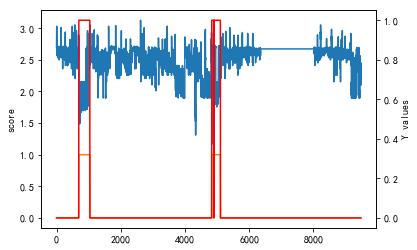

In [51]:
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(range(len(re)),re)
ax1.set_ylabel('score')

ax2 = ax1.twinx()  # this is the important function
flag=train_ay.FLAG[(day<nearday)*(day>passbyday)*(train_ax.UNIQUENO==UNIQUENO)]
ax2.plot(range(len(re)),flag, 'r')
ax2.set_ylabel('Y values')

plt.show()

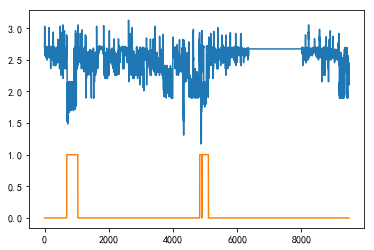

In [52]:
plt.plot(re)

In [53]:
flag_uniqueno=[]

In [54]:
if type(UNIQUENO)==int:
    UNIQUENO=[UNIQUENO]

In [55]:
for i in range(len(UNIQUENO)):
    flag_uniqueno.append(list(train_ay.FLAG[train_ay.UNIQUENO==UNIQUENO[i]]))

In [56]:
sum(flag_uniqueno[0])

612

In [57]:
#len(re)
if len(UNIQUENO)==1:
    flag_uni=flag_uniqueno[0]
else:
    flag_uni=[j for j in i for i in flag_uniqueno]

In [58]:
re=pd.DataFrame(re)
re['flag']=flag_uni

Text(0.5,1,'原始故障数据直方图')

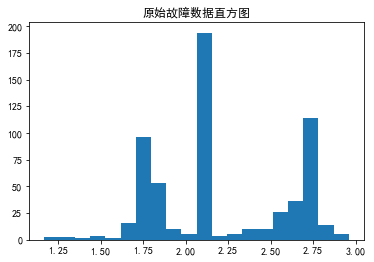

In [59]:
#flag_uniqueno
plt.hist(re[0][re.flag==1],bins=20)
plt.title("原始故障数据直方图")

Text(0.5,1,'原始健康数据直方图')

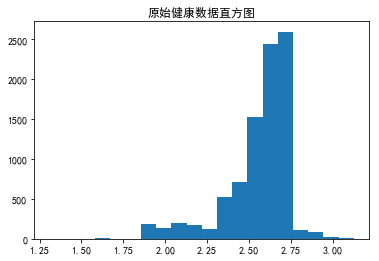

In [60]:
plt.hist(re[0][re.flag==0],bins=20)
plt.title("原始健康数据直方图")

In [61]:
np.percentile(re[0][re.flag==0],5)    ####f1

2.0601186989153297

In [62]:
np.percentile(re[0][re.flag==0],20)   ####警戒线

2.4543863614576993

In [63]:
np.percentile(re[0][re.flag==0],99)   ####f2

2.8733803323231815

# 故障数据得分清洗。大于等于警戒线的得分删除。

Text(0.5,1,'更新后故障数据分布图')

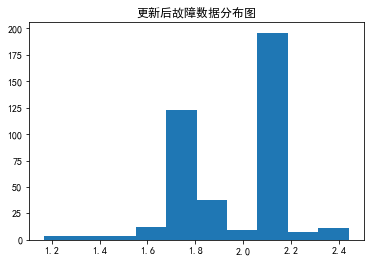

In [41]:
re_guzhang=re[0][re.flag==1]
plt.hist(re_guzhang[re_guzhang<np.percentile(re[0][re.flag==0],20)])
plt.title("更新后故障数据分布图")

In [65]:
f1=np.percentile(re_guzhang[re_guzhang<np.percentile(re[0][re.flag==0],20)],95)   ##最终f1
print(f1)

2.152748422489904


# 大于警戒线的得分纳入健康数据

In [66]:
re_health=re[0][re.flag==0]
re_health=re_health.append(re_guzhang[re_guzhang<np.percentile(re[0][re.flag==0],20)])

Text(0.5,1,'更新后健康数据的分布图')

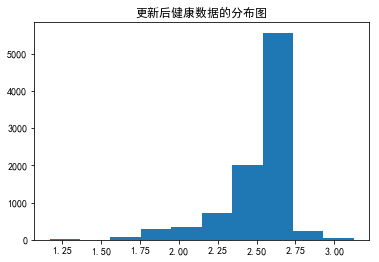

In [67]:
plt.hist(re_health)
plt.title("更新后健康数据的分布图")

In [68]:
警戒值=np.percentile(re_health,20)   ###最终警戒值
print(警戒值)

2.4094769632050137


In [69]:
f2=np.percentile(re_health,99)  ###最终f2
print(f2)

2.8691358179061948


In [70]:
pd.DataFrame([f1,警戒值,f2],index=["f1","警戒值","f2"]).to_csv("yuzhi.csv")

# 全数据得分分布 (非重点)

(array([   9.,    8.,   84.,  295.,  340.,  716., 2009., 5725.,  249.,
          42.]),
 array([1.16991746, 1.36550705, 1.56109664, 1.75668623, 1.95227582,
        2.14786541, 2.34345501, 2.5390446 , 2.73463419, 2.93022378,
        3.12581337]),
 <a list of 10 Patch objects>)

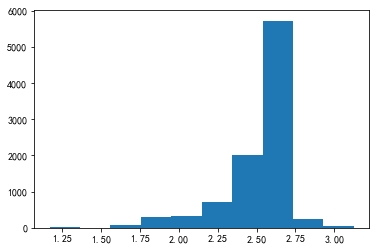

In [48]:
plt.hist(re[0])

# 设备分数排名

In [49]:
'''
nearday=max(day)
passbyday=min(day)
UNIQUENO=train_ax.UNIQUENO


re_all=[]



SCORE=pd.DataFrame(index=np.unique(day[(day<nearday)*(day>=passbyday)]),columns=np.unique(UNIQUENO))
for j in SCORE.columns:
    for i in SCORE.index: 
        data_oneday_oneid=pd.DataFrame(train_ax[((day==i)*(train_ax.UNIQUENO==j))==True],columns=train_ax.columns)
        #data_oneday_oneid=pd.DataFrame(train_ax[(day==i)*(train_ax.UNIQUENO==j),:],columns=train_ax.columns)
        oneday_oneid_score=np.zeros(data_oneday_oneid.shape[0])
        for k in range(data_oneday_oneid.shape[0]):
            oneday_oneid_score[k]=model.newdatahand(data_oneday_oneid.iloc[k,:],scorehua=False)
            re_all.append(oneday_oneid_score[k])
        if len(oneday_oneid_score)!=0 :
            SCORE.loc[i,j]=np.max(oneday_oneid_score)

SCORE.fillna(0,inplace=True)
np.argsort(np.max(SCORE,axis=0))


len(re_all)

plt.hist(re_all)

'''

'\nnearday=max(day)\npassbyday=min(day)\nUNIQUENO=train_ax.UNIQUENO\n\n\nre_all=[]\n\n\n\nSCORE=pd.DataFrame(index=np.unique(day[(day<nearday)*(day>=passbyday)]),columns=np.unique(UNIQUENO))\nfor j in SCORE.columns:\n    for i in SCORE.index: \n        data_oneday_oneid=pd.DataFrame(train_ax[((day==i)*(train_ax.UNIQUENO==j))==True],columns=train_ax.columns)\n        #data_oneday_oneid=pd.DataFrame(train_ax[(day==i)*(train_ax.UNIQUENO==j),:],columns=train_ax.columns)\n        oneday_oneid_score=np.zeros(data_oneday_oneid.shape[0])\n        for k in range(data_oneday_oneid.shape[0]):\n            oneday_oneid_score[k]=model.newdatahand(data_oneday_oneid.iloc[k,:],scorehua=False)\n            re_all.append(oneday_oneid_score[k])\n        if len(oneday_oneid_score)!=0 :\n            SCORE.loc[i,j]=np.max(oneday_oneid_score)\n\nSCORE.fillna(0,inplace=True)\nnp.argsort(np.max(SCORE,axis=0))\n\n\nlen(re_all)\n\nplt.hist(re_all)\n\n'